<img src='https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png' width="800">

# Correlation Analysis in Pyleoclim

by  [Julien Emile-Geay](https://orcid.org/0000-0001-5920-4751)

## Preamble

This tutorial is inspired by a similar one in Pyleoclim's sister package, [GeoChronR](https://nickmckay.github.io/GeoChronR/articles/correlation.html). 
The scientific premise is to compare two high-resolution paleoclimate records that have quantifiable age uncertainties: the Hulu Cave speleothem record of [Wang et al. (2001)](https://www.science.org/doi/10.1126/science.1064618) and [GISP2](https://icecores.org/inventory/gisp2) ice core record of oxygen isotopes. 

On multi-millennial timescales, the two datasets display such similar features that the well-dated Hulu Cave record, and other similar records from China and Greenland, has been used to argue for atmospheric teleconnections between the regions and support the independent chronology of GISP2 (Wang et al., 2001). In this use case, we revisit this relation quantitatively and use the age models created above, as well as geoChronR’s corEns function, to calculate the impact of age uncertainty on the correlation between these two iconic datasets. Because these datasets are not normally distributed, we use Spearman’s rank correlation to avoid the assumption of linearity.

### Goals:

* blah


**Reading Time:**

10 minutes

### Keywords

Age ensembles, Surogates, multiple hypotheses, serial correlation, significance

### Pre-requisites

None. This tutorial assumes basic knowledge of Python. If you are not familiar with this coding language, check out this tutorial: http://linked.earth/ec_workshops_py/.

### Relevant Packages

Pickle, Pyleoclim

## Data Description

- Hulu
- GISP2


## Demonstration

Let's import the packages needed for this tutorial:

In [6]:
import pickle
import pyleoclim as pyleo

### Load data 
First, the Hulu Cave dataset from Wang et al, (2001), with age ensemble. @Alex, we need more details here.

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [ka]', ylabel='d18O [permil]'>)

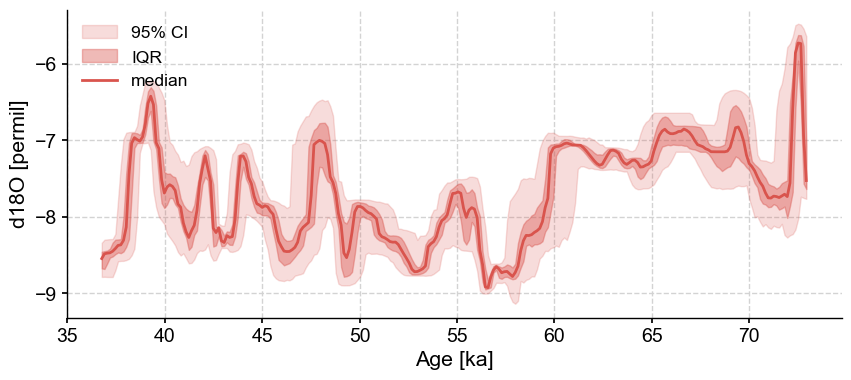

In [58]:
with open('../data/hulu_ensemble.pkl','rb') as handle:
    Hulu = pickle.load(handle)
Hulu.label = 'Hulu Cave'
Hulu.value_name = r'$\delta^{18} \mathrm{O}$'
Hulu.value_unit = '‰'
Hulu = Hulu.convert_time_unit('ky BP')
Hulu.common_time().plot_envelope()

In [59]:
len(Hulu.series_list)

1000

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [ka]', ylabel='$\\delta^{18} \\mathrm{O}$ [‰]'>)

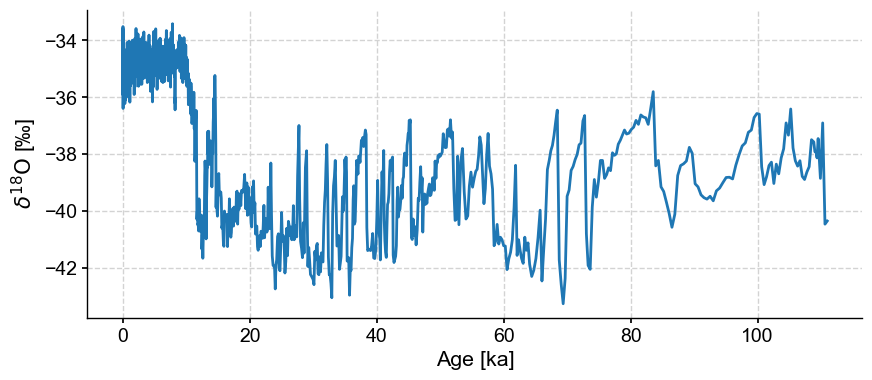

In [60]:
GISP2 = pyleo.utils.load_dataset('GISP2')
GISP2 = GISP2.convert_time_unit('ky BP')
GISP2.plot()

### Create age ensemble
Hulu already had an age ensemble, but GISP2 doesn't. For this, we use a new function in Pyleoclim called [random_time_axis](https://pyleoclim-util.readthedocs.io/en/latest/utils/introduction.html#pyleoclim.utils.tsmodel.random_time_axis):

/Users/julieneg/opt/miniconda3/envs/pyleo/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/julieneg/opt/miniconda3/envs/pyleo/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(<Figure size 1100x800 with 2 Axes>,
 {'res': <Axes: xlabel='Age [ka]', ylabel='resolution [ka]'>,
  'res_hist': <Axes: xlabel='Counts'>})

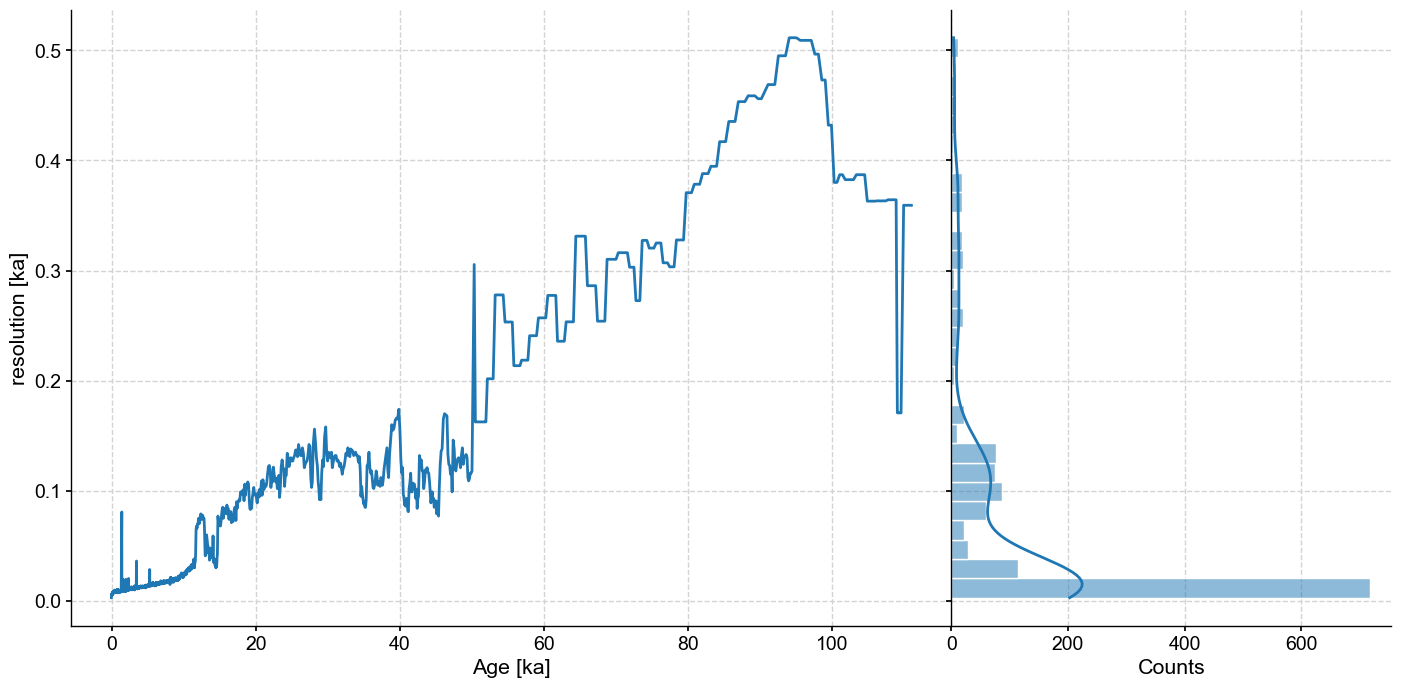

In [28]:
GISP2.resolution().dashboard()

Let's create an [EnsembleSeries](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#ensembleseries-pyleoclim-ensembleseries) object with time perturbations of $\pm100y$ with a 2% probability:

In [61]:
nEns = 1000
n = len(GISP2.time)
slist = []
for _ in range(nEns):
    pert = pyleo.utils.tsmodel.random_time_axis(n,
                                         delta_t_dist='random_choice',
                                         param =[[-0.1,0,0.1],[0.02,0.96,0.02]])
    ts = GISP2.copy()
    ts.time = GISP2.time + pert
    slist.append(ts)
GISP2e = pyleo.EnsembleSeries(slist)

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [ka]', ylabel='$\\delta^{18} \\mathrm{O}$ [‰]'>)

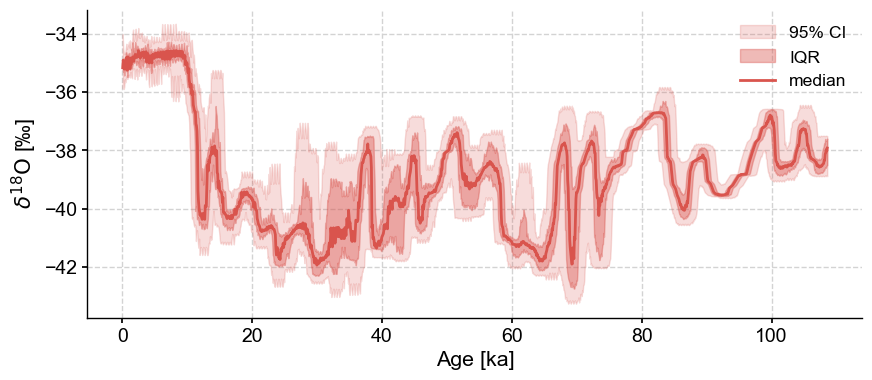

In [62]:
GISP2e.common_time().plot_envelope()

## Correlating the medians

Before delving into the ensembles, let's extract their medians and explore their correlation, to showcase a few of `Pyleoclim`'s capabilities. The default measure of association is Pearson's product-moment correlation, more commonly known as [Pearson's R](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient). 

In [65]:
Hulu_m = Hulu.common_time().quantiles(qs=[0.5]).series_list[0] # this turns it into a Series
GISP2_m = GISP2e.common_time().quantiles(qs=[0.5]).series_list[0] # this turns it into a Series
for method in ['built-in','ar1sim','phaseran']:
    corr_m = Hulu_m.correlation(GISP2_m,method=method)
    print(corr_m)

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
     -0.39747  < 1e-13    True



Evaluating association on surrogate pairs: 100%|██████████| 1000/1000 [00:00<00:00, 1513.98it/s]


  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
     -0.39747       0.21  False



Evaluating association on surrogate pairs: 100%|██████████| 1000/1000 [00:00<00:00, 1495.53it/s]

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
     -0.39747       0.08  False

